# Compare FSE/VarBugs

This portion of the notebook allows you to compare the results between the sampling-based baseline and the desugared analysis results. This will print out number of results from analyzing desugared code, the number of baselines, and the overlap between them.

To use this portion of the notebook, please set "result_location" to the location of the desugared results, and "baseline_location" to the location of the sampling-based baseline results.

In [ ]:
from scripts.count_additional_true_positives import transformation
from scripts.taxonomy import get_warning_type

#Set Baseline and Experiment
desugared_location = ""
baseline_location = ""

import json
from json import JSONEncoder

def _default(self, obj):
    return getattr(obj.__class__, "to_json", _default.default)(obj)

_default.default = JSONEncoder().default
JSONEncoder.default = _default

import logging
import copy
from pathlib import Path
from typing import Tuple

with open(baseline_location) as f:
    baselines = json.load(f)

with open(desugared_location) as f:
    experimental_results = json.load(f)

lonely_baselines = copy.deepcopy(baselines)
lonely_experimental_results = copy.deepcopy(experimental_results)

class IntRange:
    def __init__(self, lower_bound_inclusive, upper_bound_exclusive):
        self.lower_bound_inclusive = lower_bound_inclusive
        self.upper_bound_exclusive = upper_bound_exclusive

    def __contains__(self, item):
        return isinstance(item, int) and (self.lower_bound_inclusive <= item < self.upper_bound_exclusive)

    def __repr__(self):
        return f"IntRange({self.lower_bound_inclusive, self.upper_bound_exclusive})"

    def __str__(self):
        return f"[{self.lower_bound_inclusive}:{self.upper_bound_exclusive})"

    def to_json(self):
        return str(self)


for e in experimental_results:
    toks = e['original_line'].split(':')
    try:
        e['original_line'] = IntRange(int(toks[0]), int(toks[1]) + 1)
    except Exception as ex:
        e['original_line'] = []
    #print('\t'.join(["experimental", *[str(s) for s in e.values()]]).replace("\n", ""))

    if e['function_line_range'] == 'ERROR':
        e['function_line_range'] = []
    else:
        toks = e['function_line_range'].split(':')
        try:
            e['function_line_range'] = IntRange(int(toks[1]), int(toks[2]) + 1)
        except Exception as ex:
            logging.exception(f"e was {e}")
    e['presence_condition'] = str(e['presence_condition'])

import tqdm

def match_stats(baseline_result: dict, experimental_result: dict) -> Tuple:
    """
    Returns a vector of different match information.
    (a, b, c)
    a = True iff baseline and experimental have the same line number, message, and file.
    b = True iff baseline and experimental have the same message, file, and baseline is within experimental's function scope.
    c = True iff baseline's configuration is compatible with experimental's presence condition.
    """

    a = (baseline_result['sanitized_message'].lstrip().rstrip() == experimental_result['sanitized_message'].lstrip().rstrip() and \
         baseline_result['input_line'] in experimental_result['original_line'] and\
         baseline_result['input_file'].split('.')[0] == experimental_result['input_file'].split('.')[0])

    b = (baseline_result['sanitized_message'].lstrip().rstrip() == experimental_result['sanitized_message'].lstrip().rstrip() and \
         baseline_result['input_line'] in experimental_result['function_line_range'] and\
         baseline_result['input_file'].split('.')[0] == experimental_result['input_file'].split('.')[0])

    c = False

    if experimental_result['feasible'] and 'Or(None' not in experimental_result['presence_condition'] and experimental_result['presence_condition'] not in ['Or(None)', 'None'] and (a or b):  # Don't bother doing this expensive step when the file and line number are different.
        baseline_var_mapping = {}
        for var in baseline_result['configuration']:
            if type(var) is str:
                if var.startswith('DEF'):
                    baseline_var_mapping[re.sub(r"^(DEF_.*)", r"\1", var)] = True
                elif var.startswith('UNDEF'):
                    baseline_var_mapping[re.sub(r"^UN(DEF_.*)", r"\1", var)] = False
                else:
                    raise RuntimeError(f"Don't know how to handle variable {var}")

        s = Solver()
        for var, val in baseline_var_mapping.items():
            var = Bool(var)
            if val:
                s.add(var)
            else:
                s.add(Not(var))

        for mat in re.findall("DEF_[a-zA-Z0-9_]+", experimental_result['presence_condition']):
            exec(f"{mat} = Bool('{mat}')")
           
        for mat in re.findall("USE_[a-zA-Z0-9_]+", experimental_result['presence_condition']):
            exec(f"{mat} = Int('{mat}')")

        while True:
            try:
                s.add(eval(experimental_result['presence_condition']))  # TODO Definitely need to do more transformation here.
                break
            except NameError as ne:
                var = re.search("name '(.*)' is not defined", str(ne))
                exec(f"{var.group(1)} = Int('{var.group(1)}')")
        c = s.check() == sat
    return a, b, c

def tupleize(func, args): return func(*args), tuple(args)

summary = {}

# Note that results depend on the order of keys in this dictionary, because once we find a match_stats for one level we do not keep searching for the next.
#  E.g., for a given report, we will first look for results with which it has a (True, True, True) report. If it has one, we do not continue searching for
#  matches for (False, True, True), (True, False, True), etc.
result_hierarchy = {(True, True, True): 0, (False, True, True): 0, (True, False, True): 0, (True, True, False): 0, (False, True, False): 0, (False, False, True): 0, (True, False, False): 0, (False, False, False): 0}

report = []
for b in tqdm.tqdm(baselines):
    # Results are (baseline, desugared, match tuple)
    results = [(b, e, match_stats(b, e)) for e in experimental_results]
    found = False
    for r in result_hierarchy.keys():
        for res in results:
            if res[2] == r:
                found = True
                result_hierarchy[r] += 1
                # -----
                # Here is where you compile information about any specific reports you need. This block of code
                # iterates through all baselines and finds the highest level of matching that is available.
                # So, for example, if you wanted to collect all of the unmatched originals, you would uncomment out this line of code:
                #
                if (r != (True, True, True) and r != (False, True, True)):
                    report.append(res[0])
                break # DO NOT DELETE THE BREAK!
        if found:
            break

print(f"Number of baseline results: {len(baselines)}")
print(f"Number of desugared results: {len(experimental_results)}")
print(f"Number of feasible desugared results: {len(list(filter(lambda e: e['feasible'], experimental_results)))}")
print(f"Number of exact matched baselines: {result_hierarchy[(True, True, True)]}")
print(f"Number of partially matched baselines: {result_hierarchy[False, True, True]}")
print(
    f"Number of unmatched baselines: {sum(v for k, v in result_hierarchy.items() if k not in [(True, True, True), (False, True, True)])}")

# Time Analysis
This part of the notebook will compute the total time the analysis took, including both desugaring time and the analysis time.
This requires the log files produced by Sugarlyzer.

In [ ]:
import os

def get_log_files(predicate):
    for root, dirs, files in os.walk("../results/ASE_25"):
        for f in files:
            if predicate(f):
                yield f"{root}/{f}"

import re
def get_times(log_file, predicate = lambda x: True):
    dtime = 0
    atime = 0
    print(f"Reading {log_file}")
    with open(log_file,'r') as i:
        for line in i.readlines():
            line = line.lstrip().rstrip()
            if 'Analyzing file' in line and ' took ' in line and predicate(line):
                res = re.search(r'took (\d+\.\d+)s',line)
                if res != None:
                    atime += float(res.group(1))

            elif ' desugared in time:' in line and predicate(line):
                res = re.search(r' desugared in time:(\d+\.\d+)',line)
                if res != None:
                    dtime += float(res.group(1))
    return atime, dtime

for log_file in get_log_files(lambda f: f.endswith(".log") and "tosem" not in f):
    atime, dtime = get_times(log_file)
    print(f'Analysis Time: {int(atime/60)}m\nDesugaring time: {int(dtime/60)}m')


# Recover Configurations

In [ ]:
import functools

results = [f"../results/ASE_25/{f}" for f in os.listdir("../results/ASE_25") if "baseline" in f and f.endswith(".json")]
logs = [r.replace(".json", ".log") for r in results]
results_and_logs = list(zip(results, logs))
print(results_and_logs)

@functools.cache
def load_configs(config_loc):
    res = []
    for root, _, files in os.walk(config_loc):
        for f in filter(lambda f: f.endswith(".config"), files):
            with open(f"{root}/{f}", 'r') as infile:
                lines = infile.readlines()
            config = dict()
            for l in lines:
                if l.startswith("#"):
                    config[re.findall("(CONFIG[A-Z0-9_]+)", l)[0]] = False
                else:
                    toks = l.split("=")
                    config[toks[0]] = str(toks[1].strip())
            res.append((f, config))
    return res

#print(load_configs("../resources/programs/axtls/configs")[0])

import json
def recover_config(report):
    matches = [fi for fi, conf in load_configs("../resources/programs") if conf == report['configuration']]
    if len(matches) == 0:
        print("Couldn't find a match.")
    elif len(matches) > 1:
        print("Too many matches")
    else:
        report['original_config'] = matches[0]

with open("../results/ASE_25/clang.axtls.baseline.json", 'r') as inf:
    res = json.load(inf)
    for r in res:
        conf = dict()
        for entry in r['configuration']:
            conf[entry[0]] = entry[1]
        r['configuration'] = conf

#print([len(r['configuration'].keys()) for r in res])
reports = load_configs("../resources/programs")
list(map(lambda r: recover_config(r), res))
print("Done")

for alarms, log in results_and_logs:
    # Find all configs
    with open(log, 'r') as inlog:
        all_configs = set(re.findall("\d+\.config", inlog.read()))
    print(len(all_configs))


# Create Venn Diagram

ERROR:root:Expecting value: line 1 column 1 (char 0)
Traceback (most recent call last):
  File "/var/folders/vh/0xj7w79x03x2h1xb1txw1nl40000gn/T/ipykernel_13896/543737665.py", line 36, in <module>
    transformation.extend(json.load(inf))
                          ~~~~~~~~~^^^^^
  File "/Users/austin/.pyenv/versions/3.13.2/lib/python3.13/json/__init__.py", line 293, in load
    return loads(fp.read(),
        cls=cls, object_hook=object_hook,
        parse_float=parse_float, parse_int=parse_int,
        parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/Users/austin/.pyenv/versions/3.13.2/lib/python3.13/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ~~~~~~~~~~~~~~~~~~~~~~~^^^
  File "/Users/austin/.pyenv/versions/3.13.2/lib/python3.13/json/decoder.py", line 345, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/austin/.pyenv/versions

Family locations: ['../results/ICSE_25/family.toybox.json', '../results/ICSE_25/family.busybox_1_28.json', '../results/ICSE_25/family.axtls.json']
Couldn't read ../results/ICSE_25/clang.busybox.json
Couldn't read ../results/ICSE_25/infer.busybox.json


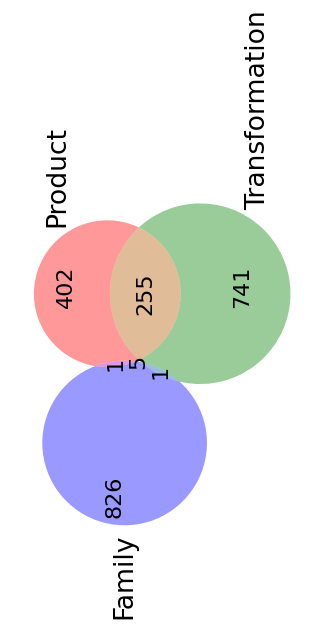

In [27]:
import matplotlib
from matplotlib_venn import venn3
from frozendict import frozendict
from taxonomy import get_warning_type
import matplotlib.pyplot as plt
import os
import json
import logging
import re
from PIL import Image

results_loc = "../results/ICSE_25"
family_locations = [f"{results_loc}/{f}" for f in os.listdir(results_loc) if f.endswith(".json") and "tosem" not in f and "family" in f]
print(f"Family locations: {family_locations}")
transformation_locations = [f"{results_loc}/{f}" for f in os.listdir(results_loc) if f.endswith(".json") and "baseline" not in f and "varbugs" not in f and "tosem" not in f and "family" not in f]
logging.info(f"Transformation locations: {transformation_locations}")
product_locations = [f"{results_loc}/{f}" for f in os.listdir(results_loc) if f.endswith(".json") and "baseline" in f and "tosem" not in f and "varbugs" not in f]
logging.info(f"Product locations: {product_locations}")

family = []
for f in family_locations:
    with open(f, 'r') as inf:
        try:
            logging.info(f"Reading {f}")
            family.extend(json.load(inf))
        except Exception as ex:
            logging.exception(ex)
            print("Couldn't read " + f)
            pass

transformation = []
for t in transformation_locations:
    with open(t, 'r') as inf:
        try:
            logging.info(f"Reading {t}")
            transformation.extend(json.load(inf))
        except Exception as ex:
            logging.exception(ex)
            print("Couldn't read " + t)
            pass


product = []
for p in product_locations:
    with open(p, 'r') as inf:
        try:
            logging.info(f"Reading {p}")
            product.extend(json.load(inf))
        except Exception as ex:
            logging.exception(ex)
            print("Couldn't read " + p)
            pass

# Extract bug information
family_summaries = set()
for f in family:
    family_summaries.add(frozendict({
        "input_file": f["input_file"].split("/")[-1],
        "type": f["taxonomy_type"],
        "line_number": int(re.findall(r":(\d+):\d+", f["err"])[0])
    }))

product_summaries = set()
for p in product:
    product_summaries.add(frozendict({
        "input_file": p["input_file"].split("/")[-1],
        "line_number": int(p["input_line"]),
        "type": str(get_warning_type(p['message'], False))
    }))

def transform_linum(linum):
    if "ERROR" in linum:
        transform_linum.counter = transform_linum.counter - 1
        return transform_linum.counter
    else:
        return int(linum.split(":")[0])
transform_linum.counter = 0

transformation_summaries = set()
for t in transformation:
    transformation_summaries.add(frozendict({
        "input_file": t["input_file"].split("/")[-1].replace(".desugared", ""),
        "line_number": transform_linum(t["original_line"]),
        "type": str(get_warning_type(t['message'], False))}))

matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots()
venn = venn3((product_summaries, transformation_summaries, family_summaries), set_labels = ("Product", "Transformation", "Family"), ax = ax)

# Rotate all subset labels (numbers)
for subset_id in ('100', '010', '001', '110', '101', '011', '111'):
    label = venn.get_label_by_id(subset_id)
    if label:
        label.set_rotation(90)

# Rotate set labels ('Product', etc.)
for text in venn.set_labels:
    text.set_rotation(90)

plt.show()

path = "/Users/austin/git/sugarlyzer-paper/resources/real_world_venn.png"
fig.savefig(path, dpi=600, bbox_inches='tight')

img = Image.open(path)
rotated = img.rotate(270, expand=True)
rotated.save(path)

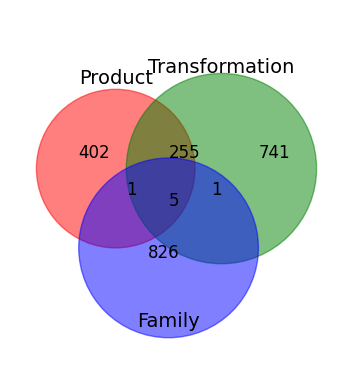

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patheffects as PathEffects

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))  # Wider aspect ratio

# Draw circles manually (x, y, radius)
circle1 = Circle((-1, 0), 1.5, color='red', alpha=0.5, label='Product')
circle2 = Circle((1, 0), 1.8, color='green', alpha=0.5, label='Transformation')
circle3 = Circle((0, -1.5), 1.7, color='blue', alpha=0.5, label='Family')

# Add circles to plot
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)

# Add labels manually
ax.text(-1.7, 0.2, '402', fontsize=12)
ax.text(0, 0.2, '255', fontsize=12)
ax.text(1.7, 0.2, '741', fontsize=12)
ax.text(-0.4, -1.7, '826', fontsize=12)
ax.text(-0.8, -0.5, '1', fontsize=12)
ax.text(0.8, -0.5, '1', fontsize=12)
ax.text(0, -0.7, '5', fontsize=12)

# Titles for the sets
ax.text(-1, 1.6, 'Product', fontsize=14, ha='center')
ax.text(1, 1.8, 'Transformation', fontsize=14, ha='center')
ax.text(0, -3, 'Family', fontsize=14, ha='center')

# Styling
ax.set_xlim(-3, 3)
ax.set_ylim(-4, 3)
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.show()